In [160]:
import torch
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# following: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/

# Read data
T = 10
path = f".\\data\\data_T{str(T)}_1.csv"
names = ['time', 'u' , 'x','delta_x', 'obs_num']
df = pd.read_csv(path,sep=',', header=0, names=names,index_col=False)
print(df.head())
print(df.shape)




       time         u         x   delta_x  obs_num
0  0.000000 -0.398684  0.000000  0.000000      1.0
1  0.526316 -0.193558 -0.419668 -0.419668      1.0
2  1.052632 -0.215139 -0.623413 -0.203745      1.0
3  1.578947  0.830190 -0.849875 -0.226462      1.0
4  2.105263  0.628167  0.024009  0.873884      1.0
(300, 5)


In [161]:
delta_T = df["time"][1] - df["time"][0]
print(delta_T)
df['dx_dt'] = df["delta_x"]/delta_T

print(df.head())

0.5263157894736842
       time         u         x   delta_x  obs_num     dx_dt
0  0.000000 -0.398684  0.000000  0.000000      1.0  0.000000
1  0.526316 -0.193558 -0.419668 -0.419668      1.0 -0.797369
2  1.052632 -0.215139 -0.623413 -0.203745      1.0 -0.387116
3  1.578947  0.830190 -0.849875 -0.226462      1.0 -0.430278
4  2.105263  0.628167  0.024009  0.873884      1.0  1.660380


In [162]:
df = df.loc[~((df['time'] == 0))]
print(df.head())

       time         u         x   delta_x  obs_num     dx_dt
1  0.526316 -0.193558 -0.419668 -0.419668      1.0 -0.797369
2  1.052632 -0.215139 -0.623413 -0.203745      1.0 -0.387116
3  1.578947  0.830190 -0.849875 -0.226462      1.0 -0.430278
4  2.105263  0.628167  0.024009  0.873884      1.0  1.660380
5  2.631579  0.552348  0.685237  0.661228      1.0  1.256333


In [163]:
# Train test split
training_data_len = math.ceil(len(df) * .8)
print(training_data_len)

# Splitting the dataset
train_data = df[:training_data_len]
test_data = df[training_data_len:]
print(train_data.shape, test_data.shape)
print(train_data.head())



228
(228, 6) (57, 6)
       time         u         x   delta_x  obs_num     dx_dt
1  0.526316 -0.193558 -0.419668 -0.419668      1.0 -0.797369
2  1.052632 -0.215139 -0.623413 -0.203745      1.0 -0.387116
3  1.578947  0.830190 -0.849875 -0.226462      1.0 -0.430278
4  2.105263  0.628167  0.024009  0.873884      1.0  1.660380
5  2.631579  0.552348  0.685237  0.661228      1.0  1.256333


In [164]:
scaler = MinMaxScaler(feature_range=(0, 1)) # StandardScaler() # 
names.append("dx_dt")
# Scaling dataset
scaled_train = scaler.fit_transform(train_data.to_numpy())
scaled_train = pd.DataFrame(scaled_train, columns=names)
print(scaled_train.shape)
print(scaled_train.head())

scaled_test = scaler.fit_transform(test_data.to_numpy())
scaled_test = pd.DataFrame(scaled_test, columns=names)
print(scaled_test.shape)


(228, 6)
       time         u         x   delta_x  obs_num     dx_dt
0  0.000000  0.403056  0.334020  0.300406      0.0  0.300406
1  0.055556  0.392256  0.318727  0.403056      0.0  0.403056
2  0.111111  0.915359  0.301729  0.392256      0.0  0.392256
3  0.166667  0.814263  0.367322  0.915359      0.0  0.915359
4  0.222222  0.776322  0.416953  0.814263      0.0  0.814263
(57, 6)


In [165]:
# define positional encoding
# def positional_encoding(T, d_model):
#     # Initialize positional encoding matrix
#     t= np.linspace(0, 1, num=T)
#     pe = np.zeros((t.shape[0], d_model))
    
#     # Compute positional encodings
#     for pos, time in enumerate(t):
#         for i in range(d_model):
#             if i % 2 == 0:
#                 pe[pos, i] = np.sin(time / (10000 ** (2 * i / d_model)))
#             else:
#                 pe[pos, i] = np.cos(time / (10000 ** (2 * (i-1) / d_model)))
    
#     return np.array(pe)



# ## Save data
# ID = []
# PE = []
# d_model  = 1
# N = 10

# for i in range(N):
#     PE += [positional_encoding(T-1, d_model)[:,d_model-1]]

# PE = np.array(PE)
# print(PE)
# PE= PE.flatten()
# print(PE.shape)

In [166]:
# PE_train = PE[:training_data_len]
# PE_test  = PE[training_data_len:]

# scaled_train["u"] = scaled_train["u"] + PE_train
# scaled_train["dx_dt"] = scaled_train["dx_dt"] + PE_train

# scaled_test["u"] = scaled_test["u"] + PE_test
# scaled_test["dx_dt"] = scaled_test["dx_dt"] + PE_test

# print(scaled_train.head())
# print(scaled_test.head())

In [169]:
# Create sequences
def to_sequences(seq_size, df):
    obs_u = df['u'].tolist()
    obs_x = df['x'].tolist()
    obs_delta_x = df['delta_x'].tolist()
    obs_dx_dt = df['dx_dt'].tolist()
    x = []
    y = []
    pred_len = 1
    
    for i in range((len(obs_x))-seq_size - 1):
        
        # window1 = obs_x[i:(i+seq_size)]  # x at time t
        # window2 = obs_u[i:(i+seq_size)]  # u at time t
        window2 = [obs_u[i:(i+seq_size)]]  # u at time t
        #after_window = [obs_delta_x[i+pred_len: i+seq_size + pred_len]]  # delta x at time t+1 ( x_t+1 - x_t = delta_x_t+1)
        #after_window = [obs_dx_dt[i+pred_len: i+seq_size + pred_len]]
        after_window = [obs_dx_dt[i+1: i+seq_size+1]]
        #window = [[x, u] for x,u in zip(window1, window2)]
        
        #x.append(window)
        x.append(window2)
        y.append(after_window)

    return np.array(x).transpose((0,2,1)), np.array(y).transpose(0,2,1)
    #return np.array(x), np.array(y).transpose(0,2,1)
sequence_size = 1

X_train, y_train = to_sequences(sequence_size, scaled_train)


# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)
print(X_train[0])
print(y_train[0])

# Create sequences and labels for testing data
X_test,  y_test = to_sequences(sequence_size, scaled_test)
# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([226, 1, 1]) torch.Size([226, 1, 1])
tensor([[0.4031]])
tensor([[0.4031]])
torch.Size([55, 1, 1]) torch.Size([55, 1, 1])


In [153]:
# # create model
tf_model = torch.torch.nn.Transformer(d_model= 1, nhead=1, num_encoder_layers=10, num_decoder_layers=10,dim_feedforward=256, batch_first=True)

c:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\pyomo_env\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [154]:
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader 

# torch.manual_seed(0)

# # Hyperparameters
# seq_length = 10  # Number of time steps to use for predictions
# batch_size = 48
# input_size = 2  
# output_size = 1
# hidden_size = 12
# num_layers = 4
# num_heads = 4
# dropout = 0.1
# num_epochs = 50
# learning_rate = 0.01


# # Create dataset and dataloaders
# source = X_train
# target = y_train
# train_dataset = TensorDataset(source, target)
# train_loader = DataLoader(train_dataset,  
#                         batch_size=batch_size,  
#                         shuffle=True)

# # Define Transformer Model
# class TimeSeriesTransformer(torch.nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_heads, dropout, output_size):
#         super(TimeSeriesTransformer, self).__init__()
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.num_heads = num_heads

#         self.transformer = torch.nn.Transformer(
#             d_model=hidden_size,
#             nhead=num_heads,
#             num_encoder_layers=num_layers,
#             num_decoder_layers=num_layers,
#             dropout=dropout,
#         )

#         self.fc_in = torch.nn.Linear(input_size, hidden_size)
#         # self.linear_layer1 = torch.torch.nn.Linear(hidden_size, 128)
#         # self.dropout_1     = torch.torch.nn.Dropout(p=dropout)
#         self.fc_out = torch.nn.Linear(hidden_size, output_size)

#     def forward(self, src, tgt):
#         src = self.fc_in(src)  # Shape: [batch_size, seq_length, hidden_size]
#         tgt = self.fc_in(tgt)

#         # Transpose for compatibility with torch.nn.Transformer
#         src = src.permute(1, 0, 2)  # Shape: [seq_length, batch_size, hidden_size]
#         tgt = tgt.permute(1, 0, 2)

#         output = self.transformer(src, tgt)  # Shape: [seq_length, batch_size, hidden_size]
#         # output = self.linear_layer1(output)
#         # output = self.dropout_1(output)
#         output = self.fc_out(output)

#         return output.permute(1, 0, 2)  # Shape: [batch_size, seq_length, input_size]


# # Instantiate model, define loss and optimizer
# model = TimeSeriesTransformer(
#     input_size=input_size,
#     hidden_size=hidden_size,
#     num_layers=num_layers,
#     num_heads=num_heads,
#     dropout=dropout,
#     output_size=output_size,
# )

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(tf_model.parameters(),lr=0.01)

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0

#     for src, tgt in train_loader:
#         optimizer.zero_grad()
#         output = model(src[:,:-1,:], src[:, 1:, :])  # We predict the next step, so target is shifted

#         loss = criterion(output, tgt[:, 1:, :])
#         loss.backward()
#         optimizer.step()

#         train_loss += loss.item() 

#     train_loss / len(list(train_loader))
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# print("Training completed.")

In [155]:
# torch.manual_seed(0)

# from torch.utils.data import TensorDataset 
# from torch.utils.data import DataLoader 

# optimizer = torch.optim.SGD(tf_model.parameters(),lr=0.01)
# loss_fn = torch.torch.nn.MSELoss()

# def train_epoch(model, optimizer, sequence_size, batch_size=64):
#     model.train()
#     losses = 0 
#     source = X_train
#     target = X_train #X_train[1:, :, :]
    
#     src_mask = tf_model.generate_square_subsequent_mask(sequence_size)
#     dataset = TensorDataset(source, target)
#     train_dataloader = DataLoader(dataset,  
#                         batch_size=batch_size,  
#                         shuffle=True)
#     for src, tgt in train_dataloader:
        
#         out = tf_model(src,tgt,src_mask)
#         optimizer.zero_grad()
        
#         loss = loss_fn(out,tgt)
#         loss.backward()
        
#         optimizer.step()
#         losses += loss.item()
#         print(loss.item())
#     return losses / len(list(train_dataloader))

# def evaluate(model, sequence_size, batch_size=64):
#     model.eval()
#     losses = 0 
#     source = X_test
#     target = X_test
    
#     src_mask = tf_model.generate_square_subsequent_mask(sequence_size)
#     dataset = TensorDataset(source, target)
#     test_dataloader = DataLoader(dataset,  
#                         batch_size=batch_size,  
#                         shuffle=True)
#     for src, tgt in test_dataloader:
#         out = tf_model(src,tgt,src_mask)
        
#         loss = loss_fn(out,tgt)
#         losses += loss.item()
#         print(loss.item())
#     return losses / len(list(test_dataloader))


In [156]:
# from timeit import default_timer as timer
# NUM_EPOCHS = 2

# for epoch in range(1, NUM_EPOCHS+1):
#     start_time = timer()
#     train_loss = train_epoch(tf_model, optimizer, sequence_size, 32)
#     end_time = timer()
#     print("---")
#     val_loss = evaluate(tf_model, sequence_size, 32)
#     print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))


In [168]:
# torch.manual_seed(0)

# from torch.utils.data import TensorDataset 
# from torch.utils.data import DataLoader 

# optimizer = torch.optim.Adamax(tf_model.parameters(),lr=0.0001)
# loss_fn = torch.torch.nn.MSELoss()

# #avg_pool_layer = torch.torch.nn.AvgPool1d(2, stride=1)
# linear_layer1 = torch.torch.nn.Linear(1, 128)
# dropout_1     = torch.torch.nn.Dropout(p=0.1)
# linear_layer2 = torch.torch.nn.Linear(128, 1)

# def train_epoch(model, optimizer, sequence_size, batch_size=64):
#     model.train()
#     losses = 0 
#     source = X_train
#     target = y_train[:, 1: , :]
    
#     src_mask = tf_model.generate_square_subsequent_mask(sequence_size)
#     dataset = TensorDataset(source, target)
#     train_dataloader = DataLoader(dataset,  
#                         batch_size=batch_size,  
#                         shuffle=False)
#     for src, tgt in train_dataloader:
#         t_src = src[:, :-1, :]
#         t_tgt = tgt
#         out = tf_model(t_src, t_tgt,src_mask)
#         #out = avg_pool_layer(out)
#         out = linear_layer1(out)
#         out = dropout_1(out)
#         out = linear_layer2(out)
#         optimizer.zero_grad()
        
#         loss = loss_fn(out,tgt)
#         loss.backward()
        
#         optimizer.step()
#         losses += loss.item()
#         # print(loss.item())
#     return losses / len(list(train_dataloader))

# from timeit import default_timer as timer
# NUM_EPOCHS = 400
# batch_size = 1000
# for epoch in range(1, NUM_EPOCHS+1):
#     start_time = timer()
#     train_loss = train_epoch(tf_model, optimizer, 9, batch_size)
#     end_time = timer()
#     print((f"Epoch: {epoch}, Train loss: {train_loss:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))



In [170]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [172]:
class TransformerModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.encoder = torch.nn.Linear(input_dim, d_model)
        self.transformer = torch.nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers, batch_first=True)
        self.decoder = torch.nn.Linear(d_model, output_dim)

    def forward(self, src, tgt):
        src = self.encoder(src)
        tgt = self.encoder(tgt)
        output = self.transformer(src, tgt)
        output = self.decoder(output)
        return output

# Instantiate the model
input_dim = 1  # Since u(t) is 1-dimensional
output_dim = 1  # Since x(t) is 1-dimensional
model = TransformerModel(input_dim, output_dim)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [176]:
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(inputs, inputs)
        loss = criterion(output, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    # Early stopping if the loss is low enough
    if avg_loss <= 0.01:
        print("Training stopped early, loss is below 0.01.")
        break


Epoch 1/200, Loss: 0.0159
Epoch 2/200, Loss: 0.0169
Epoch 3/200, Loss: 0.0130
Epoch 4/200, Loss: 0.0111
Epoch 5/200, Loss: 0.0110
Epoch 6/200, Loss: 0.0111
Epoch 7/200, Loss: 0.0099
Training stopped early, loss is below 0.01.


In [182]:

# Evaluate the model
model.eval()
outputs = []
with torch.no_grad():
    output = model(X_test, X_test)
    outputs += output
    test_loss = criterion(output, y_test)
    print(f'Test MSE Loss: {test_loss.item():.4f}')


Test MSE Loss: 0.0057


In [178]:
# #save model
model_path = ".\\trained_transformer\\toy_pytorch_model.pt"
torch.save(tf_model.state_dict(), model_path)

In [184]:
outputs = np.array(outputs)
print(X_test.shape, outputs.shape)

torch.Size([55, 1, 1]) (55, 1, 1)


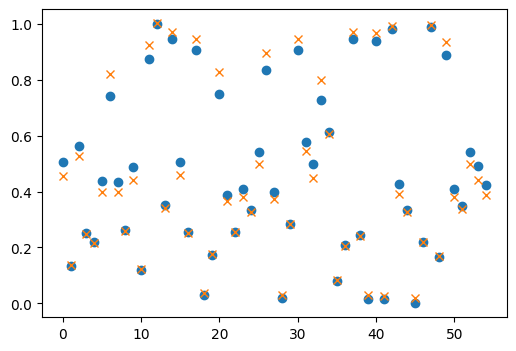

In [187]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(X_test[:,0,0], "o")
plt.plot(outputs[:,0,0] , "x")